In [1]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from PIL import Image
import time

VGG_MEAN = [103.939, 116.779, 123.68]

class VGGNet:
    """Builds VGG-16 net structure,
       load parameters from per-train models
    """
    def __init__(self, data_dict):
        self.data_dict = data_dict
        
    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name = 'conv')
        
    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name = 'fc')
    
    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name = 'bias')
    
    def conv_layer(self, x, name):
        """Builds convolution layer."""
        with tf.name_scope(name):
            conv_w = self.get_conv_filter(name)
            conv_b = self.get_bias(name)
            h = tf.nn.conv2d(
                x,
                conv_w,
                [1, 1, 1, 1],
                padding = 'SAME')
            h = tf.nn.bias_add(h, conv_b)
            h = tf.nn.relu(h)
#             print("layer %s: %s" % (name, str(h.shape)))
            return h
        
    def pooling_layer(self, x, name):
        """Builds pooling layer."""
        return tf.nn.max_pool(
            x,
            ksize = [1, 2, 2, 1],
            strides = [1, 2, 2, 1],
            padding = 'SAME',
            name = name)
    
    def fc_layer(self, x, name, activation = tf.nn.relu):
        """Builds fully-connected layer."""
        with tf.name_scope(name):
            fc_w = self.get_fc_weight(name)
            fc_b = self.get_bias(name)
            h = tf.matmul(x, fc_w)
            h = tf.nn.bias_add(h, fc_b)
#             print("layer %s: %s" % (name, str(h.shape)))
            if activation is None:
                return h
            else:
                return activation(h)
        
    def flatten_layer(self, x, name):
        """Builds flatten layer."""
        with tf.name_scope(name):
            # [batch_size, image_width, image_height, channel]
            x_shape = x.get_shape().as_list()
            dim = 1
            for d in x_shape[1:]:
                dim *= d
            x = tf.reshape(x, [-1, dim])
            return x
        
    def build(self, x_rgb):
        """Build VGG16 network structure.
        Parameters:
        - x_rgb: [1, 244, 244, 3]
        """
        start_time = time.time()
        print('building model ...')
        
        r, g, b = tf.split(x_rgb, [1, 1, 1], axis = 3)
        x_bgr = tf.concat(
            [b - VGG_MEAN[0],
             g - VGG_MEAN[1],
             r - VGG_MEAN[2]],
             axis = 3)
        assert x_bgr.get_shape().as_list()[1:] == [224, 224, 3]
        
        self.conv1_1 = self.conv_layer(x_bgr, 'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1, 'conv1_2')
        self.pool1 = self.pooling_layer(self.conv1_2, 'pool1')
        
        self.conv2_1 = self.conv_layer(self.pool1, 'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1, 'conv2_2')
        self.pool2 = self.pooling_layer(self.conv2_2, 'pool2')
        
        self.conv3_1 = self.conv_layer(self.pool2, 'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1, 'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2, 'conv3_3')
        self.pool3 = self.pooling_layer(self.conv3_3, 'pool3')
        
        self.conv4_1 = self.conv_layer(self.pool3, 'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1, 'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2, 'conv4_3')
        self.pool4 = self.pooling_layer(self.conv4_3, 'pool4')
        
        self.conv5_1 = self.conv_layer(self.pool4, 'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1, 'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2, 'conv5_3')
        self.pool5 = self.pooling_layer(self.conv5_3, 'pool5')
        """
        self.flatten5 = self.flatten_layer(self.pool5, 'flatten')
        self.fc6 = self.fc_layer(self.flatten5, 'fc6')
        self.fc7 = self.fc_layer(self.fc6, 'fc7')
        self.fc8 = self.fc_layer(self.fc7, 'fc8', activation = None)
        self.prob = tf.nn.softmax(self.fc8, name = 'prob')
        """
        print('building model finished: %4ds' % (time.time() - start_time))

W0902 00:11:32.638325 140484354754368 deprecation.py:323] From /home/shungao/application/anaconda3/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
vgg16_npy_path = 'vgg16/vgg16.npy'
content_image_path = 'images/gugong.jpg'
style_image_path = 'images/xingkong.jpg'

num_steps = 100
learning_rate = 10

lambda_conent = 0.1
lambda_style = 500

output_dir = './run_style_transfer'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# vgg16_data = np.load(vgg16_npy_path, allow_pickle=True, encoding='latin1')
# vgg16_dict = vgg16_data.item()

# vgg16_for_result = VGGNet(vgg16_dict)
# content = tf.placeholder(tf.float32, shape = [1, 224, 224, 3])
# vgg16_for_result.build(content)

In [3]:
def initial_result(shape, mean, stddev):
    initial = tf.truncated_normal(shape, mean = mean, stddev = stddev)
    return tf.Variable(initial)

def read_image(image_name):
    image = Image.open(image_name)
    np_image = np.array(image) # (224, 224, 3)
    np_image = np.asarray([np_image], dtype = np.int32) # (1, 224, 224, 3)
    return np_image

def gram_matrix(x):
    """Calculate gram matrix
    Args:
    - x: features extracted from VGG Net. shape: [1, width, height, channel]
    """
    b, w, h, ch = x.get_shape().as_list()
    features = tf.reshape(x, [b, w * h, ch]) # [ch, ch] -> (i, j)
    # [h * w, ch] matrix -transposition-> [ch, h * w] * [h * w, ch] -> [ch, ch]
    gram = tf.matmul(features, features, adjoint_a = True) / tf.constant(ch * w * h, tf.float32)
    return gram

result = initial_result((1, 224, 224, 3), 127.5, 20)
content_val = read_image(content_image_path)
style_val = read_image(style_image_path)

content = tf.placeholder(tf.float32, shape=[1, 224, 224, 3])
style = tf.placeholder(tf.float32, shape=[1, 224, 224, 3])

vgg16_data = np.load(vgg16_npy_path, allow_pickle=True, encoding='latin1')
vgg16_dict = vgg16_data.item()
vgg_for_content = VGGNet(vgg16_dict)
vgg_for_style = VGGNet(vgg16_dict)
vgg_for_result = VGGNet(vgg16_dict)

vgg_for_content.build(content)
vgg_for_style.build(style)
vgg_for_result.build(result)

content_features = [
    vgg_for_content.conv1_2,
#     vgg_for_content.conv2_2,
#     vgg_for_content.conv3_3,
#     vgg_for_content.conv4_3,
#     vgg_for_content.conv5_3,
]

result_content_features = [
    vgg_for_result.conv1_2,
#     vgg_for_result.conv2_2,
#     vgg_for_result.conv3_3,
#     vgg_for_result.conv4_3,
#     vgg_for_result.conv5_3,
]

style_features = [
#     vgg_for_style.conv1_2,
#     vgg_for_style.conv2_2,
#     vgg_for_style.conv3_3,
     vgg_for_style.conv4_3,
#     vgg_for_style.conv5_3,
]
style_gram = [gram_matrix(feature) for feature in style_features]

result_style_feature = [
#     vgg_for_result.conv1_2,
#     vgg_for_result.conv2_2,
#     vgg_for_result.conv3_3,
     vgg_for_result.conv4_3,
#     vgg_for_result.conv5_3,
]
result_style_gram = [gram_matrix(feature) for feature in result_style_feature]

content_loss = tf.zeros(1, tf.float32)
# zip: [1, 2], [3, 4], zip([1, 2], [3, 4]) -> [(1, 3), (2, 4)]
# shape: [1, width, height, channel]
for c, c_ in zip(content_features, result_content_features):
    content_loss += tf.reduce_mean((c - c_) ** 2, [1, 2, 3])
    
style_loss = tf.zeros(1, tf.float32)
for s, s_ in zip(style_gram, result_style_gram):
    style_loss += tf.reduce_mean((s - s_) ** 2, [1, 2])

loss = content_loss * lambda_conent + style_loss * lambda_style
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

building model ...
building model finished:    0s
building model ...
building model finished:    0s
building model ...
building model finished:    0s


W0902 00:11:34.090357 140484354754368 deprecation.py:323] From /home/shungao/application/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for step in range(num_steps):
        loss_value, content_loss_value, style_loss_value, _ = sess.run(
                [loss, content_loss, style_loss, train_op],
                feed_dict = {
                    content: content_val,
                    style: style_val
                })
        print("step: %d, loss_value: %8.4f, content_loss_value: %8.4f, style_loss: %8.4f" \
             % (step + 1, loss_value[0], content_loss_value[0], style_loss_value[0]))
        
        result_image_path = os.path.join(output_dir, 'result-%05d.jpg' % (step + 1))
        result_val = result.eval(sess)[0]
        result_val = np.clip(result_val, 0, 255)
        image_arr = np.asarray(result_val, np.uint8)
        image = Image.fromarray(image_arr)
        image.save(result_image_path)


step: 1, loss_value: 8835.3369, content_loss_value: 51457.8984, style_loss:   7.3791
step: 2, loss_value: 7056.2412, content_loss_value: 38520.1523, style_loss:   6.4085
step: 3, loss_value: 5499.2656, content_loss_value: 30791.8691, style_loss:   4.8402
step: 4, loss_value: 4813.5205, content_loss_value: 27102.3730, style_loss:   4.2066
step: 5, loss_value: 4076.9917, content_loss_value: 25033.6523, style_loss:   3.1473
step: 6, loss_value: 3721.2368, content_loss_value: 23815.5234, style_loss:   2.6794
step: 7, loss_value: 3391.7793, content_loss_value: 23111.5410, style_loss:   2.1613
step: 8, loss_value: 3233.2871, content_loss_value: 22712.2656, style_loss:   1.9241
step: 9, loss_value: 3133.2788, content_loss_value: 22380.8262, style_loss:   1.7904
step: 10, loss_value: 3018.2747, content_loss_value: 22026.3984, style_loss:   1.6313
step: 11, loss_value: 2890.9043, content_loss_value: 21505.1504, style_loss:   1.4808
step: 12, loss_value: 2782.7168, content_loss_value: 20885.6465

step: 98, loss_value: 732.0377, content_loss_value: 4226.3076, style_loss:   0.6188
step: 99, loss_value: 745.0342, content_loss_value: 4290.5210, style_loss:   0.6320
step: 100, loss_value: 716.4666, content_loss_value: 4314.6567, style_loss:   0.5700


(224, 224)


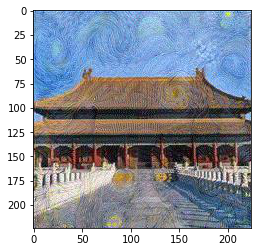

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

image_name = 'result-00100.jpg'
img = Image.open(os.path.join(output_dir, image_name))
print(img.size)

img_arr = np.asarray(img)
%matplotlib inline
imshow(img_arr)